<a href="https://colab.research.google.com/github/Santiago8888/Kin/blob/dev/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"dzetaa","key":"00431f0f6a6a7725bdbe7b053b8ce916"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)


mkdir: cannot create directory ‘.kaggle’: File exists


In [3]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content

- path is now set to: {/content}
 95% 257M/271M [00:02<00:00, 92.3MB/s]
100% 271M/271M [00:03<00:00, 93.5MB/s]
 97% 529M/544M [00:09<00:00, 49.4MB/s]
100% 544M/544M [00:09<00:00, 58.1MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 115MB/s]


In [0]:
!unzip \*.zip


In [0]:
! mkdir training
! mkdir testing

In [0]:
! mv train training/train
! mv test testing/test

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
import os
 
dirpath = os.getcwd()
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(dirpath + '/training', transform=train_transforms)
test_data = datasets.ImageFolder(dirpath + '/testing', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [9]:
model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 28178969.82it/s]


In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [12]:
import time
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 6.485 seconds
Device = cuda; Time per batch: 0.009 seconds


In [0]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [15]:
torch.cuda.is_available()

True

In [0]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

In [0]:
torch.save(model.state_dict(), 'checkpoint.pth')


In [46]:
model.eval()
for inputs, labels in testloader:
  print(labels)
  print(inputs.size())
  inputs, labels = inputs.to(device), labels.to(device)
  
  logps = model.forward(inputs)
  #print(logps)
  batch_loss = criterion(logps, labels)
  print(batch_loss)

  break

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([64, 3, 224, 224])
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


In [0]:
import helper

In [45]:
print(inputs[0].to(device).shape)
print(model.forward(inputs[0].to(device)))
inputs[0].shape

torch.Size([3, 224, 224])


RuntimeError: ignored

In [48]:
inputs[:1].size()

torch.Size([1, 3, 224, 224])

In [60]:
img = inputs[0]
img


tensor([[[-1.5014, -1.5699, -1.6042,  ..., -0.9363, -0.9192, -0.9363],
         [-1.5357, -1.6213, -1.6555,  ..., -0.9363, -0.9192, -0.9363],
         [-1.5528, -1.6384, -1.6727,  ..., -0.9363, -0.9192, -0.9363],
         ...,
         [ 0.9646,  0.9817,  0.9817,  ...,  0.9988,  1.0159,  0.3994],
         [ 0.9646,  0.9817,  0.9817,  ...,  0.8104,  0.8447,  0.4508],
         [ 0.9646,  0.9817,  0.9817,  ...,  0.7077,  1.0844,  0.8104]],

        [[-1.0028, -1.0728, -1.1078,  ..., -0.4426, -0.4251, -0.4426],
         [-1.0378, -1.1253, -1.1604,  ..., -0.4426, -0.4251, -0.4426],
         [-1.0728, -1.1604, -1.1954,  ..., -0.4426, -0.4251, -0.4426],
         ...,
         [ 1.1681,  1.1856,  1.1856,  ...,  0.5553,  0.6429,  0.1001],
         [ 1.1681,  1.1856,  1.1856,  ...,  0.3452,  0.4328,  0.1001],
         [ 1.1681,  1.1856,  1.1856,  ...,  0.2927,  0.6604,  0.3803]],

        [[-0.1835, -0.2532, -0.2881,  ...,  1.0539,  1.0714,  1.0539],
         [-0.2184, -0.3055, -0.3404,  ...,  1

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.cpu().numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [59]:
img

torch.Size([3, 224, 224])

In [0]:
import numpy as np

AttributeError: ignored

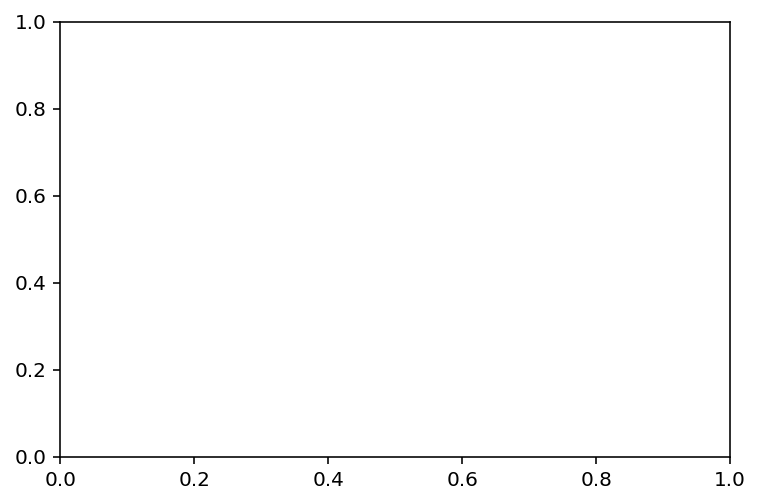

In [56]:
imshow(img)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

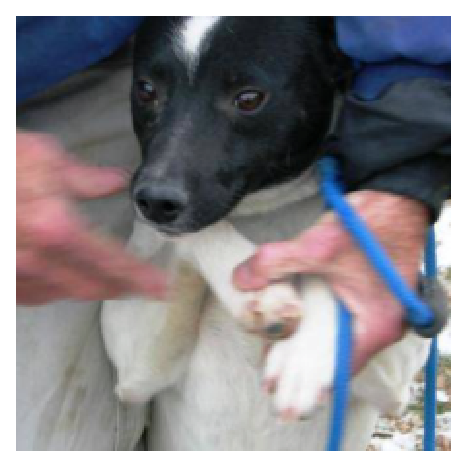

In [64]:
imshow(img)

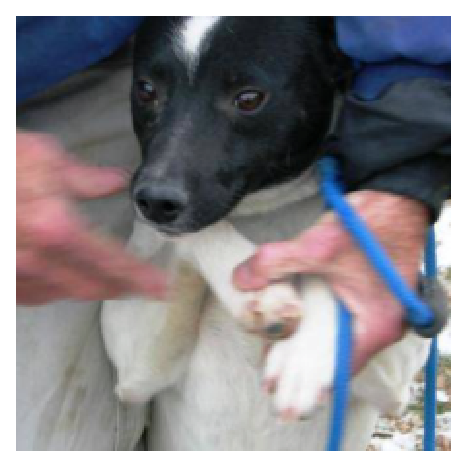

In [65]:
imshow(img)


In [0]:
def predict(imagepath):
    model.eval()
    image = image_transform(imagepath)
    image1 = image[None,:,:,:]
    ps=torch.exp(model(image1))
    topconf, topclass = ps.topk(1, dim=1)
    if topclass.item() == 1:
        return {'class':'dog','confidence':str(topconf.item())}
    else:
        return {'class':'cat','confidence':str(topconf.item())}

In [0]:
def image_transform(image):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    imagetensor = test_transforms(image)
    return imagetensor

In [75]:
predict(img)

TypeError: ignored

In [73]:
!ls testing/test

10000.jpg  11609.jpg  1966.jpg	3573.jpg  5180.jpg  6789.jpg  8396.jpg
10001.jpg  1160.jpg   1967.jpg	3574.jpg  5181.jpg  678.jpg   8397.jpg
10002.jpg  11610.jpg  1968.jpg	3575.jpg  5182.jpg  6790.jpg  8398.jpg
10003.jpg  11611.jpg  1969.jpg	3576.jpg  5183.jpg  6791.jpg  8399.jpg
10004.jpg  11612.jpg  196.jpg	3577.jpg  5184.jpg  6792.jpg  839.jpg
10005.jpg  11613.jpg  1970.jpg	3578.jpg  5185.jpg  6793.jpg  83.jpg
10006.jpg  11614.jpg  1971.jpg	3579.jpg  5186.jpg  6794.jpg  8400.jpg
10007.jpg  11615.jpg  1972.jpg	357.jpg   5187.jpg  6795.jpg  8401.jpg
10008.jpg  11616.jpg  1973.jpg	3580.jpg  5188.jpg  6796.jpg  8402.jpg
10009.jpg  11617.jpg  1974.jpg	3581.jpg  5189.jpg  6797.jpg  8403.jpg
1000.jpg   11618.jpg  1975.jpg	3582.jpg  518.jpg   6798.jpg  8404.jpg
10010.jpg  11619.jpg  1976.jpg	3583.jpg  5190.jpg  6799.jpg  8405.jpg
10011.jpg  1161.jpg   1977.jpg	3584.jpg  5191.jpg  679.jpg   8406.jpg
10012.jpg  11620.jpg  1978.jpg	3585.jpg  5192.jpg  67.jpg    8407.jpg
10013.jpg  11621.jpg  19

In [0]:
from torchvision import transforms


In [0]:
img=mpimg.imread('testing/test/10000.jpg')

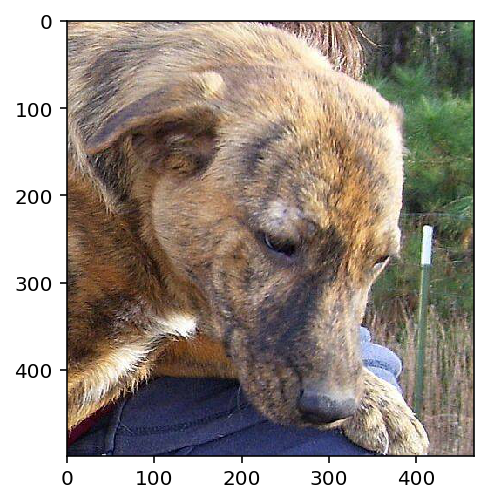

In [79]:
imgplot = plt.imshow(img)

In [0]:
from PIL import Image


def image_transform(imagepath):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    image = Image.open(imagepath)
    imagetensor = test_transforms(image)
    return imagetensor


def predict(imagepath):
    print('path', imagepath)
    model.eval()
    #summary(model, input_size=(3,244,244))
    image = image_transform(imagepath)
    print('size', image.size()) 
    image1 = image.unsqueeze(1)
    print('Good')
    image1.to(device)
    logps = model(image)
    print('Excelent')    
    ps=torch.exp(logps)
    print('Excelente')
    return
    topconf, topclass = ps.topk(1, dim=1)
    if topclass.item() == 1:
        return {'class':'dog','confidence':str(topconf.item())}
    else:
        return {'class':'cat','confidence':str(topconf.item())}

In [151]:
predict('testing/test/10000.jpg')

path testing/test/10000.jpg
size torch.Size([3, 224, 224])
Good


RuntimeError: ignored

In [152]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [154]:
for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    print(inputs.size())
    break


torch.Size([64, 3, 224, 224])


In [120]:
model.size()

AttributeError: ignored

In [113]:
 for inputs, labels in testloader[:1]:
    inputs, labels = inputs.to(device), labels.to(device)
    print(labels)

TypeError: ignored

In [116]:
trainloader[0]

TypeError: ignored

In [0]:
for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)

In [119]:
for inputs, labels in testloader:
  print(inputs.size())


torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size

In [0]:
def predict(imagepath, verbose=False):
    model.eval()
    image = image_transform(imagepath)
    image1 = image[None,:,:,:]
    image1 = image1.to(device)
    ps=torch.exp(model(image1))
    topconf, topclass = ps.topk(1, dim=1)
    if topclass.item() == 1:
        return {'class':'dog','confidence':str(topconf.item())}
    else:
        return {'class':'cat','confidence':str(topconf.item())}

In [178]:
predict('testing/test/10004.jpg')

{'class': 'cat', 'confidence': '1.0'}

In [190]:
for i in range(100,200):
  print(predict('testing/test/10' + str(i) + '.jpg'))

{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'cat', 'confidence': '1.0'}
{'class': 'c

In [186]:
str(1)

'1'

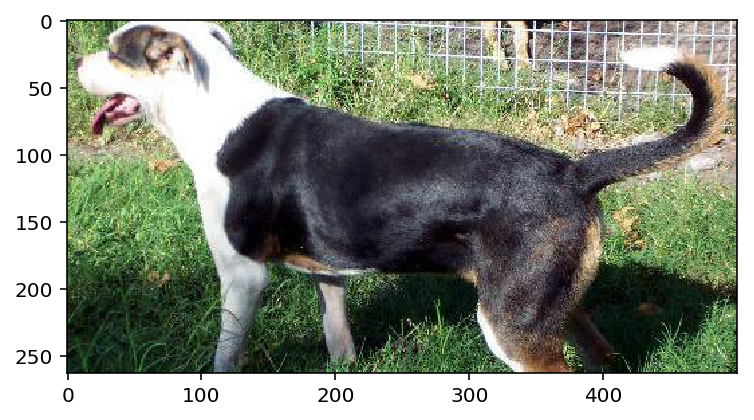

In [173]:
imgplot = plt.imshow(mpimg.imread('testing/test/10003.jpg'))